In [1]:
!pip install -r requirements.txt

--- Logging error ---
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/pip/_internal/utils/logging.py", line 177, in emit
    self.console.print(renderable, overflow="ignore", crop=False, style=style)
  File "/usr/local/lib/python3.9/dist-packages/pip/_vendor/rich/console.py", line 1673, in print
    extend(render(renderable, render_options))
  File "/usr/local/lib/python3.9/dist-packages/pip/_vendor/rich/console.py", line 1305, in render
    for render_output in iter_render:
  File "/usr/local/lib/python3.9/dist-packages/pip/_internal/utils/logging.py", line 134, in __rich_console__
    for line in lines:
  File "/usr/local/lib/python3.9/dist-packages/pip/_vendor/rich/segment.py", line 249, in split_lines
    for segment in segments:
  File "/usr/local/lib/python3.9/dist-packages/pip/_vendor/rich/console.py", line 1283, in render
    renderable = rich_cast(renderable)
  File "/usr/local/lib/python3.9/dist-packages/pip/_vendor/rich/protocol.py", line 36

In [2]:
import sys
import os

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.autograd import Variable

import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import copy

import warnings

from sklearn.preprocessing import StandardScaler

warnings.filterwarnings('ignore')

In [3]:
from src.cddm.utils import *
from src.cddm.continual_learning import continual_learning
from src.cddm.models import GRU

In [4]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

# Hyperparameters initialization

In [5]:
problem = 'plasticity-rve'
model_name = 'gru'
data_folder = 'data/rve'
result_folder = 'result'
    
SAVE_MODELS = False
SAVE_DATA = True
 
input_size = 3        # three strain components
output_size = 3       # three stress components
seq_len = 101         # number of pseudo-time steps : 0-100
hidden_size = 128     # number of hidden states for GRU
num_layers = 2        # number of GRU cells 

optimizer_name = 'Adam'
lr = 0.01
weight_decay = 1e-6
n_epochs = 1000
alpha = 0.95          # pruning parameter

seed = 0

tasks = ['B', 'C', 'A']      # sequence of tasks (with order)

    
if problem == 'plasticity-plates':
    file_names = [f'{data_folder}/{task}.pkl' for task in tasks]
else:
    file_names = [f'{data_folder}/{task}.pickle' for task in tasks]
        
num_tasks = len(file_names)
 
num_val = 100                      # number of validation paths for every task
num_test = 100                     # number of test paths for every task
nums_train = [800, 100, 100]       # number of training paths for every task; len(nums_train) == num_tasks

set_seed(seed)

# Network initialization

In [6]:
# Initialize the network (GRU)

net = GRU(input_size=input_size, seq_len=seq_len, hidden_size=hidden_size, 
          num_layers=num_layers, output_size=output_size, device=device).to(device)

In [7]:
# Creating directories and path to save results

if not os.path.exists(result_folder):
            os.mkdir(result_folder)

if SAVE_MODELS:
    dict_names = {}
    case_name = f'{problem}_'
    for i, task in enumerate(tasks):
        case_name += f'{task}-'

    case_name = case_name[:-1] 
    path_to_save = f"{model_name}_{case_name}_seed{seed}_num-layers{num_layers}_hidden{hidden_size}_lr{lr}_alpha{alpha}.pth"
else:
    path_to_save = f"model.pth"

# Training and evaluation

In [8]:
# Training the model on the given sequence of tasks

print(f">>>>>>>>>>>>>>>>>>>{nums_train} TRAINING POINTS<<<<<<<<<<<<<<<<<<<<")           
                           
net = continual_learning(net, 
                         file_names=file_names, alpha=alpha, 
                         optimizer_name=optimizer_name, scheduler=None,
                         n_epochs=n_epochs, lr=lr, weight_decay=weight_decay, 
                         device=device, 
                         nums_train=nums_train,
                         num_val=num_val,
                         num_test=num_test,
                         seed=seed,
                         path_to_save=path_to_save,
                         result_folder=result_folder,
                         problem=problem
                        )

>>>>>>>>>>>>>>>>>>>[800, 100, 100] TRAINING POINTS<<<<<<<<<<<<<<<<<<<<
['data/rve/B.pickle', 'data/rve/C.pickle', 'data/rve/A.pickle']
TRAIN PATHS:  800
-------------------TASK 1------------------------------
epoch: 0, Train Loss: 6.506e-01, Val Loss: 4.062e-01
epoch: 10, Train Loss: 1.583e-02, Val Loss: 1.395e-02
epoch: 20, Train Loss: 5.322e-03, Val Loss: 6.299e-03
epoch: 30, Train Loss: 2.778e-03, Val Loss: 3.287e-03
epoch: 40, Train Loss: 2.411e-03, Val Loss: 3.291e-03
epoch: 50, Train Loss: 2.345e-03, Val Loss: 2.605e-03
epoch: 60, Train Loss: 1.722e-03, Val Loss: 2.677e-03
epoch: 70, Train Loss: 4.160e-03, Val Loss: 4.686e-03
epoch: 80, Train Loss: 2.960e-03, Val Loss: 2.661e-03
epoch: 90, Train Loss: 1.277e-03, Val Loss: 2.016e-03
epoch: 100, Train Loss: 2.084e-03, Val Loss: 3.968e-03
epoch: 110, Train Loss: 3.141e-03, Val Loss: 3.977e-03
epoch: 120, Train Loss: 1.073e-03, Val Loss: 1.832e-03
epoch: 130, Train Loss: 1.018e-03, Val Loss: 1.614e-03
epoch: 140, Train Loss: 1.591e-0

In [9]:
# Evaluation of the model

all_losses = {}
all_errors = {}

losses, errors = eval(net, file_names, nums_train=nums_train, num_val=num_val, num_test=num_test, problem=problem)         
    
for i in range(len(nums_train)):
    all_losses[f"{tasks[i]}_{nums_train[i]}points"] = losses[i]
    all_errors[f"{tasks[i]}_{nums_train[i]}points"] = errors[i]

    
df_losses = pd.DataFrame([all_losses])
df_errors = pd.DataFrame([all_errors])
    
print(df_errors)

loss:  0.0006275613559409976
error: 2.555%
------------------
loss:  0.0010662557324394584
error: 2.901%
------------------
loss:  0.00134734355378896
error: 3.439%
------------------
   B_800points  C_100points  A_100points
0      2.55456     2.901251     3.438597


# Saving results

In [10]:
if SAVE_DATA:
    if not os.path.exists(result_folder):
        os.mkdir(result_folder)
            
    dict_names = {}
    case_name = f'{problem}_'
    for i, task in enumerate(tasks):
        dict_names[i] = f'{task}'
        case_name += f'{task}-'

    case_name = case_name[:-1]    
    df_errors.rename(index = dict_names, inplace = True)
        
    if len(tasks) > 1:
        df_errors.to_csv(f"{result_folder}/{case_name}_error_seed{seed}_num-layers{num_layers}_hidden{hidden_size}_lr{lr}_alpha{alpha}.csv", index=False)
    else:
        df_errors.to_csv(f"{result_folder}/{case_name}_error_seed{seed}_num-layers{num_layers}_hidden{hidden_size}_lr{lr}.csv", index=False)
            
if os.path.exists(f"{result_folder}/model.pth"):
     os.remove(f"{result_folder}/model.pth") 
            
    
if os.path.exists(f"{result_folder}/masks_model.pth"):
      os.remove(f"{result_folder}/masks_model.pth")  

# Plotting predictions

In [11]:
x_tests = []
y_tests = []
y_preds = []

for task_id in range(len(tasks)):
    x_train, y_train, x_val, y_val, x_test, y_test, x_mean, x_std, y_mean, y_std = process_data(file_names[task_id], 
                                                                                                num_train=nums_train[task_id], 
                                                                                                num_val=num_val, 
                                                                                                num_test=num_test
                                                                                                )

    net.set_task(task_id)
    y_pred = net(x_test).detach()
    
    x_tests.append( (x_test * x_std + x_mean).cpu().numpy() )
    y_tests.append( (y_test * y_std + y_mean).cpu().numpy() )
    y_preds.append( (y_pred * y_std + y_mean).cpu().numpy() )

In [12]:
colors  = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:gray']
sample = 35

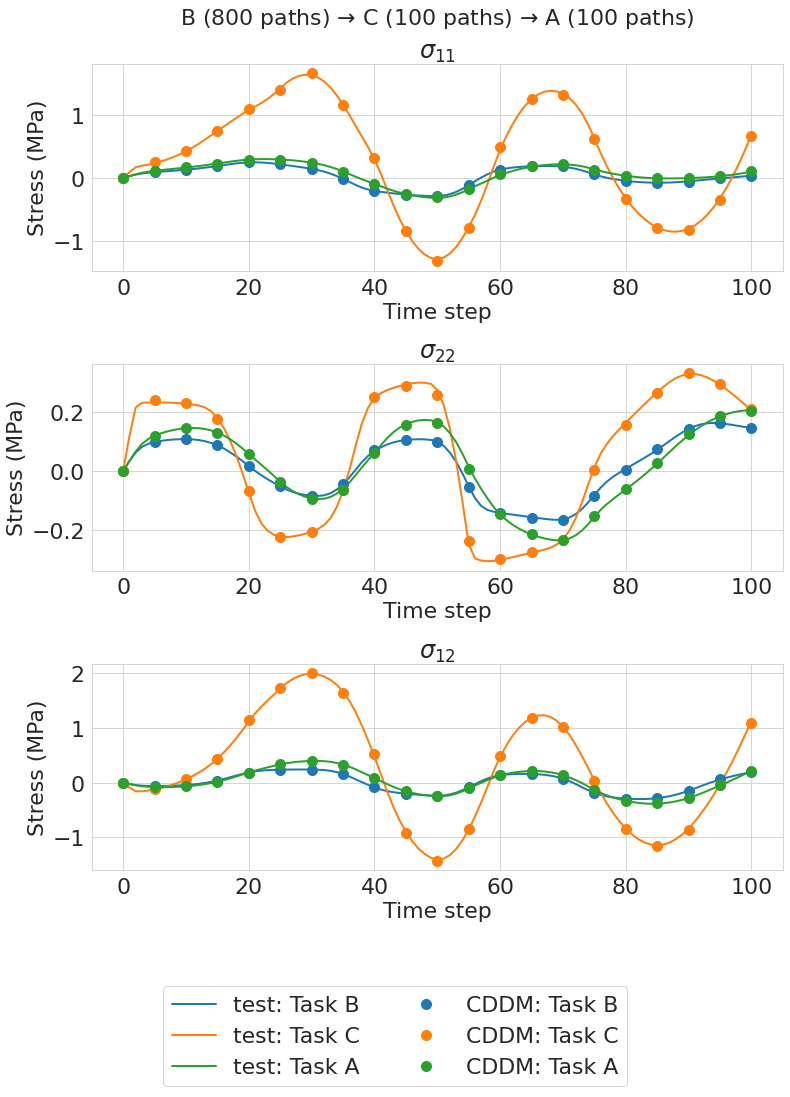

In [13]:
sns.set_style("whitegrid")

xticks = [i for i in range(0, seq_len, 10)]

sigma = [r'$\sigma_{11}$', r'$\sigma_{22}$', r'$\sigma_{12}$']

fig, ax = plt.subplots(len(sigma), 1)
fig.set_size_inches(12, 16)

time = [i for i in range(101)]
for i in range(len(sigma)):

    for task_id in range(num_tasks):
        ax[i].plot(time, y_tests[task_id][sample][:, i], 
                linewidth=2, markersize=5, color = colors[task_id])

    for task_id in range(num_tasks):
        ax[i].errorbar(time[::5], y_preds[task_id][sample][:, i][::5], 
                    fmt='o', linewidth=1, markersize=10, color = colors[task_id])
        
    component = sigma[i]

    ax[i].set_ylabel('Stress (MPa)', fontsize=22)
    ax[i].set_xlabel('Time step', fontsize=22)
    ax[i].set_title(component, fontsize=24)
    ax[i].xaxis.set_tick_params(labelsize=22)
    ax[i].yaxis.set_tick_params(labelsize=22)


legend =  [f'test: Task {tasks[task_id]}' for task_id in range(num_tasks)] + [f'CDDM: Task {tasks[task_id]}' for task_id in range(num_tasks)]
fig.legend(legend, fontsize=22, loc='lower center', ncol=2)

fig.suptitle(fr'{tasks[0]} ({nums_train[0]} paths) $\to$ {tasks[1]} ({nums_train[1]} paths) $\to$ {tasks[2]} ({nums_train[2]} paths)', fontsize=22, y=0.95)
plt.subplots_adjust(left=0.1,
                    bottom=0.2, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.45)

#plt.savefig(f'rve_{case_name}_sigma_800-{num_train}points.pdf')
plt.show()